In [2]:
larger_dataset_base_dir = '/'

In [3]:
import os
import re
import numpy as np 
import tensorflow as tf
from Bio import SeqIO 
from keras import layers
from keras import optimizers
from keras import models

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
file_name = 'fantom5_human_enhancer.fa'
enhancers = []
for record in SeqIO.parse(file_name, "fasta"):
    sequence = re.sub('[0123456789]','',str(record.seq))
    if len(sequence) != 401:
      print("STOP")
      break
    enhancers.append(sequence)
    
print(len(enhancers))

32693


In [5]:
negative_file_name = 'random_seq_with_required_length.fasta'
negative_file_name1 = 'random_seq_with_required_length1.fasta'
non_enhancers = []
for record in SeqIO.parse(negative_file_name, "fasta"):
    sequence = re.sub('[0123456789]','',str(record.seq))
    if len(sequence) != 401:
      print("STOP")
      break
    non_enhancers.append(sequence)
    
print(len(non_enhancers))


13200


In [6]:
def reverse_genetically(input_seq):
  sequence = input_seq.upper()
  rev_seq = []
  for k in range(len(sequence)):
    if sequence[k] == 'A':
      rev_seq.append('T') 
    elif sequence[k] == 'T':
      rev_seq.append('A')
    elif sequence[k] == 'C':
      rev_seq.append('G') 
    elif sequence[k] == 'G':
      rev_seq.append('C') 
      
  if len(rev_seq) != 401:
    print(len(rev_seq))
  return ''.join(rev_seq)

In [7]:
for k in range(len(non_enhancers)):
  non_enhancers.append(reverse_genetically(non_enhancers[k]))

In [8]:
for record in SeqIO.parse(negative_file_name1, "fasta"):
    sequence = re.sub('[0123456789]','',str(record.seq))[:401]
    if len(sequence) != 401:
      print(len(sequence))
      break
    non_enhancers.append(sequence)

In [9]:
print(len(non_enhancers))
np.random.shuffle(non_enhancers)

36800


In [10]:
import sys
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.lines import Line2D 

def last_2_bits(x):
	return x & 3

def hindex_to_xy(hindex, N):
	positions = [
					[0, 0],
					[0, 1],
					[1, 1],
					[1, 0]
				]

	tmp = positions[last_2_bits(hindex)]
	hindex = hindex >> 2

    # 2. iteratively compute coords
	x = tmp[0]
	y = tmp[1]

	n = 4
	while (n <= N):

		n2 = int(n / 2)
		pos_in_small_square = last_2_bits(hindex)

		if(pos_in_small_square == 0): # lower left
			tmp = x
			x = y
			y = tmp
		elif(pos_in_small_square == 1): # upper left
			x = x
			y = y + n2
		elif(pos_in_small_square == 2): # upper right
			x = x + n2
			y = y + n2
		elif(pos_in_small_square == 3): # lower right
			tmp = y
			y = (n2 - 1) - x
			x = (n2 - 1) - tmp
			x = x + n2

		hindex = hindex >> 2
		n *= 2

	return x, y
	
def draw_hilbert(order, fig_width, fig_height):

	fig, ax = plt.subplots()

	# Make graph square
	fig.set_size_inches(fig_width,fig_height)

	# Move graph window a little left and down
	# scatter([-0.1],[-0.1],s=0.01)     

	N = 2**order;
	prev = (0, 0)

	print("drawing...")

	for i in range(N*N):
		curr = hindex_to_xy(i, N)
		# print(prev, curr)

		# line from prev to curr
		h_line = [prev, curr]
		(h_line_x, h_line_y) = zip(*h_line)
		ax.add_line(Line2D(h_line_x, h_line_y, linewidth=1, color='blue'))

		prev = curr

		if(i % 1000 == 0):
			print(i, " done")

	plt.plot()
	plt.show()

def write_pixel_list_hilbert(order, file_name):
	point_list = []
	N = 2**order;
	prev = (0, 0)

	print("-- writing --")

	pixel_count = 0
	with open(file_name, "w") as pixel_file:	
		for i in range(N*N):
			curr = hindex_to_xy(i, N)
			point_list.append(curr)		
			pixel_file.write(str(curr) + '\n')
			pixel_count += 1

	print("PixelCount: ", pixel_count)
	return point_list

In [11]:
point_list = write_pixel_list_hilbert(5,'fantom_point_list.txt')

-- writing --
PixelCount:  1024


drawing...
0  done
1000  done


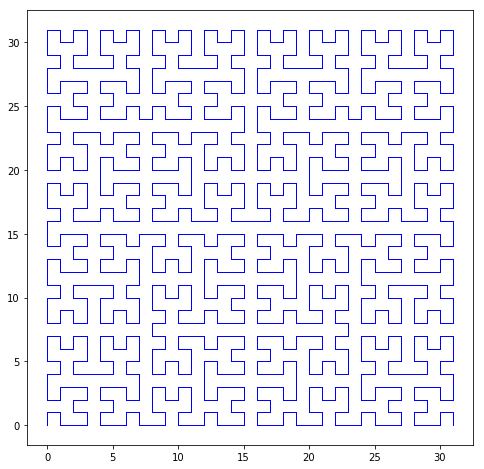

In [12]:
draw_hilbert(5,8,8)

In [13]:
mapping = dict()
mapping['A'] = np.array([1,0,0,0])
mapping['T'] = np.array([0,1,0,0])
mapping['C'] = np.array([0,0,1,0])
mapping['G'] = np.array([0,0,0,1])

In [14]:
positive_dataset = np.zeros((len(enhancers),32,32,4))
negative_dataset = np.zeros((len(non_enhancers),32,32,4))

In [15]:
def make_image(sequence):
  image_array = np.ones((32,32,4))
  for k in range(len(sequence)):
    x,y=point_list[k]
    image_array[x][y] = mapping[sequence[k].upper()]
    
  return image_array

In [16]:
positive_sample_count = 0

for k in range(len(enhancers)):
  if 'N' not in enhancers[k]:
    positive_dataset[k] = make_image(enhancers[k])
    positive_sample_count+=1

In [17]:
negative_sample_count = 0
for k in range(len(non_enhancers)):
  if 'N' not in non_enhancers[k]:
    negative_dataset[k] = make_image(non_enhancers[k])
    negative_sample_count+=1


In [18]:
def image_data_generator(positive_data, negative_data, min_index, max_index , shuffle = True, batch_size = 128):
  if min_index is None:
    min_index = 0
  if max_index is None: 
    max_index = min(positive_sample_count, negative_sample_count)
    
  i = min_index
  
  while 1:
    if shuffle:
      rows = np.random.randint(min_index, max_index, batch_size)
    else:
      if i+batch_size>=max_index: 
        i = min_index
      rows = np.arange(i,min(i+batch_size, max_index))
      
    samples = np.zeros((batch_size,32,32,4))
    targets = np.zeros(batch_size)
    
    for k,row in enumerate(rows):
      seed = np.random.randint(1,1000000000000)
      if seed%2 == 1:
        samples[k] = positive_data[row]
        targets[k] = 1
      elif seed%2 == 0:
        samples[k] = negative_data[row]
        targets[k] = 0
  
    yield samples,targets
      

In [19]:
def broadcast_function(input_array):
  output_array = np.zeros((32,32,1))
  
  for i in range(32):
    for j in range(32):
      output_array[i][j][0] = input_array[i][j]
      
      
  return output_array

In [20]:
#Functional Data Generator
def func_image_data_generator(positive_data, negative_data, min_index, max_index , shuffle = True, batch_size = 128):
  if min_index is None:
    min_index = 0
  if max_index is None: 
    max_index = min(positive_sample_count, negative_sample_count)
    
  i = min_index
  
  while 1:
    if shuffle:
      rows = np.random.randint(min_index, max_index, batch_size)
    else:
      if i+batch_size>=max_index: 
        i = min_index
      rows = np.arange(i,min(i+batch_size, max_index))
      
    samples0 = np.zeros((batch_size,32,32,1))
    samples1 = np.zeros((batch_size,32,32,1))
    samples2 = np.zeros((batch_size,32,32,1))
    samples3 = np.zeros((batch_size,32,32,1))
    targets = np.zeros(batch_size)
    
    for k,row in enumerate(rows):
      seed = np.random.randint(1,1000000000000)
      if seed%2 == 1:
        samples0[k] = np.reshape(positive_data[row,:,:,0], positive_data[row,:,:,0].shape+(1,)) #broadcast_function(positive_data[row,:,:,0])
        samples1[k] = np.reshape(positive_data[row,:,:,1], positive_data[row,:,:,1].shape+(1,))
        samples2[k] = np.reshape(positive_data[row,:,:,2], positive_data[row,:,:,2].shape+(1,))
        samples3[k] = np.reshape(positive_data[row,:,:,3], positive_data[row,:,:,3].shape+(1,))
        targets[k] = 1
      elif seed%2 == 0:
        samples0[k] = np.reshape(negative_data[row,:,:,0], negative_data[row,:,:,0].shape+(1,)) #broadcast_function(negative_data[row,:,:,0])   
        samples1[k] = np.reshape(negative_data[row,:,:,1], negative_data[row,:,:,1].shape+(1,))
        samples2[k] = np.reshape(negative_data[row,:,:,2], negative_data[row,:,:,2].shape+(1,))
        samples3[k] = np.reshape(negative_data[row,:,:,3], negative_data[row,:,:,3].shape+(1,))
        targets[k] = 0
        
    
    yield [samples0,samples1, samples2, samples3],targets
    

In [21]:
b_size = 256
train_generator = image_data_generator(positive_dataset, negative_dataset , 0, 26000, shuffle = True , batch_size = b_size)
valid_generator = image_data_generator(positive_dataset, negative_dataset , 26001, 32000, shuffle = True , batch_size = b_size)

In [22]:
#functional generator declaration 
func_b_size = 256
func_train_generator = func_image_data_generator(positive_dataset, negative_dataset , 0, 26000, shuffle = True , batch_size = func_b_size)
func_valid_generator = func_image_data_generator(positive_dataset, negative_dataset , 26001, 32000, shuffle = True , batch_size = func_b_size)

In [23]:
#Model definition 

model = models.Sequential()
model.add(layers.Conv2D(64,(3,3), activation = 'relu', input_shape = (32,32,4)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3), activation= 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(256,(3,3), activation= 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        2368      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

In [24]:
#This is the functional API version of the inception net 

from keras.models import Model 
from keras import layers
from keras import Input 
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten

First_Layer_Input = Input(shape=(32,32,1), dtype='float',name='Channel1')
Second_Layer_Input = Input(shape=(32,32,1), dtype='float',name='Channel2')
Third_Layer_Input = Input(shape=(32,32,1), dtype='float',name='Channel3')
Fourth_Layer_Input = Input(shape=(32,32,1), dtype='float',name='Channel4')

First_Layer_Conv1 = layers.Conv2D(64, (3,3), activation = 'relu', strides = 1)(First_Layer_Input)
Second_Layer_Conv1 = layers.Conv2D(64, (3,3), activation = 'relu', strides = 1)(Second_Layer_Input)
Third_Layer_Conv1 = layers.Conv2D(64, (3,3), activation = 'relu', strides = 1)(Third_Layer_Input)
Fourth_Layer_Conv1 = layers.Conv2D(64, (3,3), activation = 'relu', strides = 1)(Fourth_Layer_Input)

First_Layer_MaxPooling1 = layers.MaxPooling2D((2, 2), strides=(1, 1))(First_Layer_Conv1)
Second_Layer_MaxPooling1 = layers.MaxPooling2D((2, 2), strides=(1, 1))(Second_Layer_Conv1)
Third_Layer_MaxPooling1 = layers.MaxPooling2D((2, 2), strides=(1, 1))(Third_Layer_Conv1)
Fourth_Layer_MaxPooling1 = layers.MaxPooling2D((2, 2), strides=(1, 1))(Fourth_Layer_Conv1)

First_Layer_Conv2 = layers.Conv2D(128, (3,3), activation = 'relu', strides = 1)(First_Layer_MaxPooling1)
Second_Layer_Conv2 = layers.Conv2D(128, (3,3), activation = 'relu', strides = 1)(Second_Layer_MaxPooling1)
Third_Layer_Conv2 = layers.Conv2D(128, (3,3), activation = 'relu', strides = 1)(Third_Layer_MaxPooling1)
Fourth_Layer_Conv2 = layers.Conv2D(128, (3,3), activation = 'relu', strides = 1)(Fourth_Layer_MaxPooling1)


First_Layer_MaxPooling2 = layers.MaxPooling2D((2, 2), strides=(1, 1))(First_Layer_Conv2)
Second_Layer_MaxPooling2 = layers.MaxPooling2D((2, 2), strides=(1, 1))(Second_Layer_Conv2)
Third_Layer_MaxPooling2 = layers.MaxPooling2D((2, 2), strides=(1, 1))(Third_Layer_Conv2)
Fourth_Layer_MaxPooling2 = layers.MaxPooling2D((2, 2), strides=(1, 1))(Fourth_Layer_Conv2)


First_Layer_Conv3 = layers.Conv2D(256, (3,3), activation = 'relu', strides = 1)(First_Layer_MaxPooling2)
Second_Layer_Conv3 = layers.Conv2D(256, (3,3), activation = 'relu', strides = 1)(Second_Layer_MaxPooling2)
Third_Layer_Conv3 = layers.Conv2D(256, (3,3), activation = 'relu', strides = 1)(Third_Layer_MaxPooling2)
Fourth_Layer_Conv3 = layers.Conv2D(256, (3,3), activation = 'relu', strides = 1)(Fourth_Layer_MaxPooling2)


First_Layer_MaxPooling3 = layers.MaxPooling2D((2, 2), strides=(1, 1))(First_Layer_Conv3)
Second_Layer_MaxPooling3 = layers.MaxPooling2D((2, 2), strides=(1, 1))(Second_Layer_Conv3)
Third_Layer_MaxPooling3 = layers.MaxPooling2D((2, 2), strides=(1, 1))(Third_Layer_Conv3)
Fourth_Layer_MaxPooling3 = layers.MaxPooling2D((2, 2), strides=(1, 1))(Fourth_Layer_Conv3)

First_Layer_MaxPooling3 = Flatten()(First_Layer_MaxPooling3)
Second_Layer_MaxPooling3 = Flatten()(Second_Layer_MaxPooling3)
Third_Layer_MaxPooling3 = Flatten()(Third_Layer_MaxPooling3)
Fourth_Layer_MaxPooling3 = Flatten()(Fourth_Layer_MaxPooling3)


Feed_forward_layer_0 = layers.Dense(256,activation = 'relu')(First_Layer_MaxPooling3)
branch_1_output = layers.Dense(1, activation = 'sigmoid')(Feed_forward_layer_0)
Feed_forward_layer_1 = layers.Dense(256,activation = 'relu')(Second_Layer_MaxPooling3)
branch_2_output = layers.Dense(1, activation = 'sigmoid')(Feed_forward_layer_1)
Feed_forward_layer_2 = layers.Dense(256,activation = 'relu')(Third_Layer_MaxPooling3)
branch_3_output = layers.Dense(1, activation = 'sigmoid')(Feed_forward_layer_2)
Feed_forward_layer_3 = layers.Dense(256,activation = 'relu')(Fourth_Layer_MaxPooling3)
branch_4_output = layers.Dense(1, activation = 'sigmoid')(Feed_forward_layer_3)

output = layers.concatenate([branch_1_output,branch_1_output,branch_1_output,branch_1_output], axis = 1)

main_output = layers.Dense(1, activation = 'sigmoid')(output)

functional_api_model = Model(inputs = [First_Layer_Input, Second_Layer_Input, Third_Layer_Input, Fourth_Layer_Input], outputs=[main_output])



In [25]:
functional_api_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Channel1 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 30, 30, 64)   640         Channel1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 29, 29, 64)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 27, 27, 128)  73856       max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
max_poolin

In [26]:
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-5), metrics=['acc'])

In [27]:
functional_api_model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-5), metrics=['acc'])

In [28]:
history = model.fit_generator(train_generator , steps_per_epoch=100, epochs = 550 , validation_data=valid_generator, validation_steps=50)

Epoch 1/550
100/100 [==============================] - 12s 124ms/step - loss: 0.6943 - acc: 0.4967 - val_loss: 0.6919 - val_acc: 0.5018
Epoch 2/550
100/100 [==============================] - 2s 18ms/step - loss: 0.6923 - acc: 0.5171 - val_loss: 0.6907 - val_acc: 0.5187
Epoch 3/550
100/100 [==============================] - 2s 18ms/step - loss: 0.6915 - acc: 0.5250 - val_loss: 0.6889 - val_acc: 0.4983
Epoch 4/550
100/100 [==============================] - 2s 18ms/step - loss: 0.6898 - acc: 0.5356 - val_loss: 0.6866 - val_acc: 0.6595
Epoch 5/550
100/100 [==============================] - 2s 18ms/step - loss: 0.6874 - acc: 0.5523 - val_loss: 0.6836 - val_acc: 0.6727
Epoch 6/550
100/100 [==============================] - 2s 18ms/step - loss: 0.6847 - acc: 0.5732 - val_loss: 0.6780 - val_acc: 0.5841
Epoch 7/550
100/100 [==============================] - 2s 18ms/step - loss: 0.6813 - acc: 0.5744 - val_loss: 0.6745 - val_acc: 0.6903
Epoch 8/550
100/100 [==============================] - 2s 18

Epoch 62/550
100/100 [==============================] - 2s 17ms/step - loss: 0.2063 - acc: 0.9185 - val_loss: 0.1904 - val_acc: 0.9250
Epoch 63/550
100/100 [==============================] - 2s 18ms/step - loss: 0.2081 - acc: 0.9165 - val_loss: 0.1884 - val_acc: 0.9257
Epoch 64/550
100/100 [==============================] - 2s 19ms/step - loss: 0.2036 - acc: 0.9179 - val_loss: 0.1927 - val_acc: 0.9237
Epoch 65/550
100/100 [==============================] - 2s 20ms/step - loss: 0.1979 - acc: 0.9226 - val_loss: 0.1792 - val_acc: 0.9280
Epoch 66/550
100/100 [==============================] - 2s 19ms/step - loss: 0.2016 - acc: 0.9204 - val_loss: 0.1957 - val_acc: 0.9196
Epoch 67/550
100/100 [==============================] - 2s 18ms/step - loss: 0.1973 - acc: 0.9215 - val_loss: 0.1847 - val_acc: 0.9283
Epoch 68/550
100/100 [==============================] - 2s 18ms/step - loss: 0.1930 - acc: 0.9254 - val_loss: 0.1790 - val_acc: 0.9307
Epoch 69/550
100/100 [==============================] -

100/100 [==============================] - 2s 21ms/step - loss: 0.1183 - acc: 0.9537 - val_loss: 0.1158 - val_acc: 0.9567
Epoch 183/550
100/100 [==============================] - 2s 18ms/step - loss: 0.1179 - acc: 0.9541 - val_loss: 0.1193 - val_acc: 0.9541
Epoch 184/550
100/100 [==============================] - 2s 19ms/step - loss: 0.1160 - acc: 0.9554 - val_loss: 0.1414 - val_acc: 0.9441
Epoch 185/550
100/100 [==============================] - 2s 18ms/step - loss: 0.1169 - acc: 0.9552 - val_loss: 0.1135 - val_acc: 0.9561
Epoch 186/550
100/100 [==============================] - 2s 18ms/step - loss: 0.1116 - acc: 0.9570 - val_loss: 0.1412 - val_acc: 0.9431
Epoch 187/550
100/100 [==============================] - 2s 19ms/step - loss: 0.1114 - acc: 0.9579 - val_loss: 0.1329 - val_acc: 0.9473
Epoch 188/550
100/100 [==============================] - 2s 19ms/step - loss: 0.1099 - acc: 0.9582 - val_loss: 0.1254 - val_acc: 0.9509
Epoch 189/550
100/100 [==============================] - 2s 18

100/100 [==============================] - 2s 18ms/step - loss: 0.0766 - acc: 0.9714 - val_loss: 0.1120 - val_acc: 0.9566
Epoch 303/550
100/100 [==============================] - 2s 18ms/step - loss: 0.0806 - acc: 0.9704 - val_loss: 0.1164 - val_acc: 0.9577
Epoch 304/550
100/100 [==============================] - 2s 19ms/step - loss: 0.0788 - acc: 0.9703 - val_loss: 0.0996 - val_acc: 0.9625
Epoch 305/550
100/100 [==============================] - 2s 18ms/step - loss: 0.0817 - acc: 0.9692 - val_loss: 0.1398 - val_acc: 0.9452
Epoch 306/550
100/100 [==============================] - 2s 18ms/step - loss: 0.0802 - acc: 0.9689 - val_loss: 0.1039 - val_acc: 0.9605
Epoch 307/550
100/100 [==============================] - 2s 18ms/step - loss: 0.0773 - acc: 0.9705 - val_loss: 0.0958 - val_acc: 0.9640
Epoch 308/550
100/100 [==============================] - 2s 19ms/step - loss: 0.0797 - acc: 0.9694 - val_loss: 0.1155 - val_acc: 0.9538
Epoch 309/550
100/100 [==============================] - 2s 25

100/100 [==============================] - 2s 18ms/step - loss: 0.0560 - acc: 0.9795 - val_loss: 0.1119 - val_acc: 0.9586
Epoch 423/550
100/100 [==============================] - 2s 19ms/step - loss: 0.0569 - acc: 0.9792 - val_loss: 0.0959 - val_acc: 0.9645
Epoch 424/550
100/100 [==============================] - 2s 18ms/step - loss: 0.0580 - acc: 0.9791 - val_loss: 0.1041 - val_acc: 0.9623
Epoch 425/550
100/100 [==============================] - 2s 18ms/step - loss: 0.0559 - acc: 0.9782 - val_loss: 0.1266 - val_acc: 0.9536
Epoch 426/550
100/100 [==============================] - 2s 18ms/step - loss: 0.0550 - acc: 0.9799 - val_loss: 0.0948 - val_acc: 0.9655
Epoch 427/550
100/100 [==============================] - 2s 18ms/step - loss: 0.0574 - acc: 0.9784 - val_loss: 0.0978 - val_acc: 0.9646
Epoch 428/550
100/100 [==============================] - 2s 18ms/step - loss: 0.0527 - acc: 0.9807 - val_loss: 0.1049 - val_acc: 0.9624
Epoch 429/550
100/100 [==============================] - 2s 18

100/100 [==============================] - 2s 19ms/step - loss: 0.0379 - acc: 0.9861 - val_loss: 0.1026 - val_acc: 0.9651
Epoch 543/550
100/100 [==============================] - 2s 18ms/step - loss: 0.0333 - acc: 0.9880 - val_loss: 0.1199 - val_acc: 0.9583
Epoch 544/550
100/100 [==============================] - 2s 19ms/step - loss: 0.0363 - acc: 0.9875 - val_loss: 0.1004 - val_acc: 0.9649
Epoch 545/550
100/100 [==============================] - 2s 19ms/step - loss: 0.0358 - acc: 0.9870 - val_loss: 0.0905 - val_acc: 0.9689
Epoch 546/550
100/100 [==============================] - 2s 19ms/step - loss: 0.0348 - acc: 0.9874 - val_loss: 0.0989 - val_acc: 0.9657
Epoch 547/550
100/100 [==============================] - 2s 21ms/step - loss: 0.0384 - acc: 0.9865 - val_loss: 0.0965 - val_acc: 0.9663
Epoch 548/550
100/100 [==============================] - 2s 18ms/step - loss: 0.0367 - acc: 0.9864 - val_loss: 0.1115 - val_acc: 0.9621
Epoch 549/550
100/100 [==============================] - 2s 19

In [29]:
func_history = functional_api_model.fit_generator(func_train_generator , steps_per_epoch=100, 
                                                  epochs = 400 , validation_data=func_valid_generator, validation_steps=50)

Epoch 1/400
100/100 [==============================] - 7s 73ms/step - loss: 0.6934 - acc: 0.4986 - val_loss: 0.6931 - val_acc: 0.4962
Epoch 2/400
100/100 [==============================] - 7s 67ms/step - loss: 0.6929 - acc: 0.4954 - val_loss: 0.6920 - val_acc: 0.4994
Epoch 3/400
100/100 [==============================] - 7s 67ms/step - loss: 0.6910 - acc: 0.5020 - val_loss: 0.6899 - val_acc: 0.5016
Epoch 4/400
100/100 [==============================] - 7s 67ms/step - loss: 0.6891 - acc: 0.4932 - val_loss: 0.6869 - val_acc: 0.4980
Epoch 5/400
100/100 [==============================] - 7s 67ms/step - loss: 0.6851 - acc: 0.5021 - val_loss: 0.6837 - val_acc: 0.5005
Epoch 6/400
100/100 [==============================] - 7s 68ms/step - loss: 0.6821 - acc: 0.4990 - val_loss: 0.6810 - val_acc: 0.5017
Epoch 7/400
100/100 [==============================] - 7s 73ms/step - loss: 0.6796 - acc: 0.4984 - val_loss: 0.6773 - val_acc: 0.4979
Epoch 8/400
100/100 [==============================] - 7s 71ms

Epoch 62/400
100/100 [==============================] - 7s 68ms/step - loss: 0.6394 - acc: 0.7407 - val_loss: 0.6392 - val_acc: 0.7465
Epoch 63/400
100/100 [==============================] - 7s 67ms/step - loss: 0.6403 - acc: 0.7396 - val_loss: 0.6411 - val_acc: 0.7290
Epoch 64/400
100/100 [==============================] - 7s 70ms/step - loss: 0.6404 - acc: 0.7367 - val_loss: 0.6394 - val_acc: 0.7401
Epoch 65/400
100/100 [==============================] - 7s 67ms/step - loss: 0.6397 - acc: 0.7412 - val_loss: 0.6411 - val_acc: 0.7346
Epoch 66/400
100/100 [==============================] - 7s 67ms/step - loss: 0.6406 - acc: 0.7348 - val_loss: 0.6439 - val_acc: 0.7408
Epoch 67/400
100/100 [==============================] - 7s 68ms/step - loss: 0.6397 - acc: 0.7405 - val_loss: 0.6369 - val_acc: 0.7530
Epoch 68/400
100/100 [==============================] - 7s 67ms/step - loss: 0.6379 - acc: 0.7410 - val_loss: 0.6385 - val_acc: 0.7505
Epoch 69/400
100/100 [==============================] -

100/100 [==============================] - 7s 70ms/step - loss: 0.5912 - acc: 0.7749 - val_loss: 0.5916 - val_acc: 0.7798
Epoch 183/400
100/100 [==============================] - 7s 68ms/step - loss: 0.5899 - acc: 0.7802 - val_loss: 0.5914 - val_acc: 0.7750
Epoch 184/400
100/100 [==============================] - 7s 66ms/step - loss: 0.5886 - acc: 0.7817 - val_loss: 0.5942 - val_acc: 0.7665
Epoch 185/400
100/100 [==============================] - 7s 66ms/step - loss: 0.5882 - acc: 0.7826 - val_loss: 0.5895 - val_acc: 0.7812
Epoch 186/400
100/100 [==============================] - 7s 70ms/step - loss: 0.5895 - acc: 0.7780 - val_loss: 0.5955 - val_acc: 0.7654
Epoch 187/400
100/100 [==============================] - 7s 66ms/step - loss: 0.5886 - acc: 0.7794 - val_loss: 0.5926 - val_acc: 0.7724
Epoch 188/400
100/100 [==============================] - 7s 67ms/step - loss: 0.5889 - acc: 0.7765 - val_loss: 0.5928 - val_acc: 0.7617
Epoch 189/400
100/100 [==============================] - 7s 68

100/100 [==============================] - 7s 68ms/step - loss: 0.5474 - acc: 0.8015 - val_loss: 0.5640 - val_acc: 0.7721
Epoch 303/400
100/100 [==============================] - 7s 68ms/step - loss: 0.5483 - acc: 0.7996 - val_loss: 0.5598 - val_acc: 0.7751
Epoch 304/400
100/100 [==============================] - 7s 68ms/step - loss: 0.5435 - acc: 0.8012 - val_loss: 0.5582 - val_acc: 0.7744
Epoch 305/400
100/100 [==============================] - 7s 68ms/step - loss: 0.5457 - acc: 0.7986 - val_loss: 0.5567 - val_acc: 0.7812
Epoch 306/400
100/100 [==============================] - 7s 68ms/step - loss: 0.5461 - acc: 0.7984 - val_loss: 0.5569 - val_acc: 0.7827
Epoch 307/400
100/100 [==============================] - 7s 69ms/step - loss: 0.5442 - acc: 0.8007 - val_loss: 0.5568 - val_acc: 0.7740
Epoch 308/400
100/100 [==============================] - 7s 67ms/step - loss: 0.5402 - acc: 0.8067 - val_loss: 0.5608 - val_acc: 0.7727
Epoch 309/400
100/100 [==============================] - 7s 68

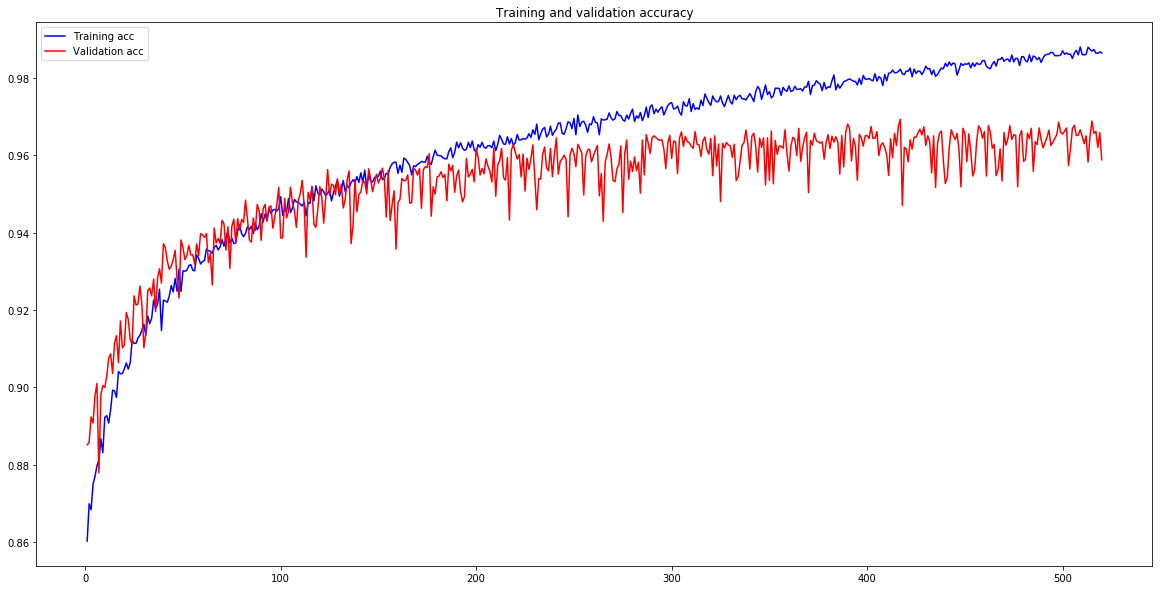

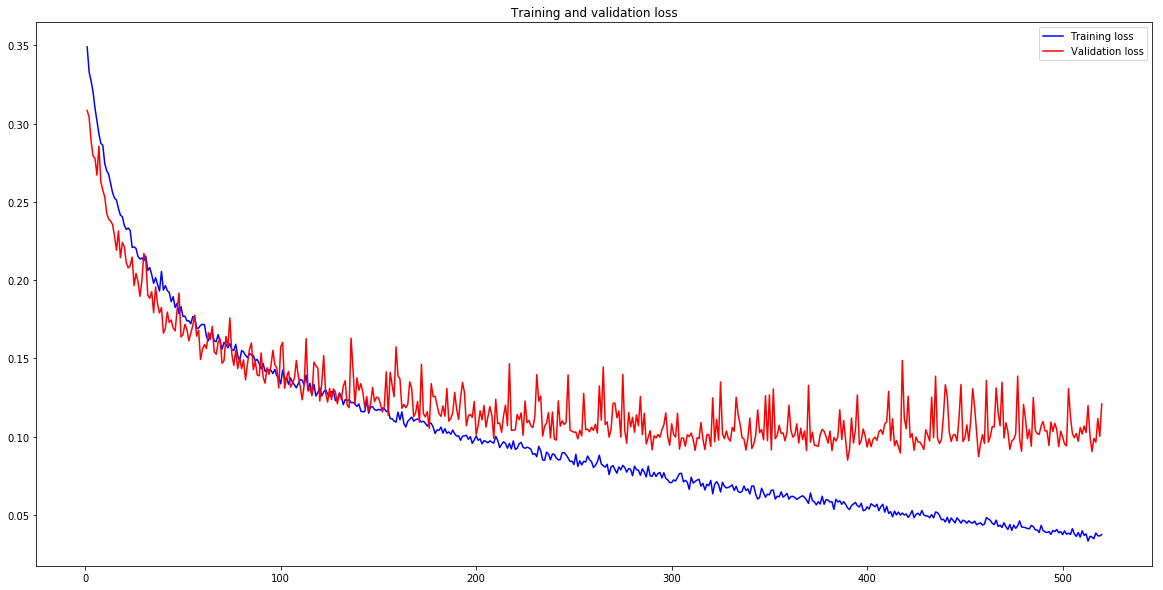

In [30]:
import matplotlib.pyplot as plt

acc = history.history['acc'][30:700]
val_acc = history.history['val_acc'][30:700]
loss = history.history['loss'][30:700]
val_loss = history.history['val_loss'][30:700]

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(20,10))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(20,10))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()


In [32]:
model.save('models/deep_cnn_3_layer_3X3_drop_fifty.h5')

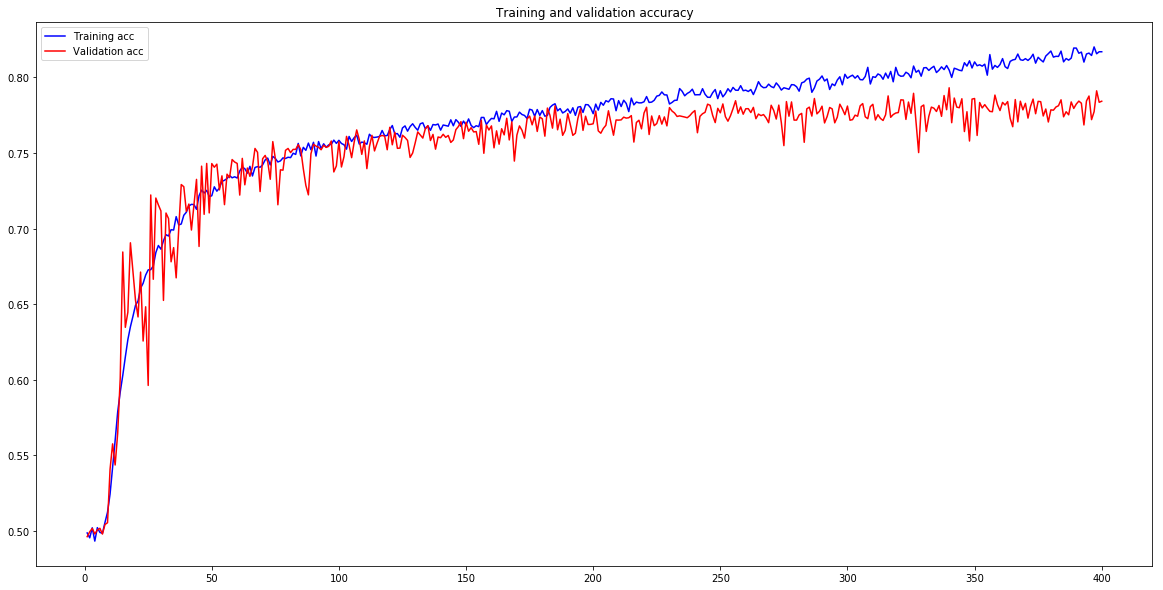

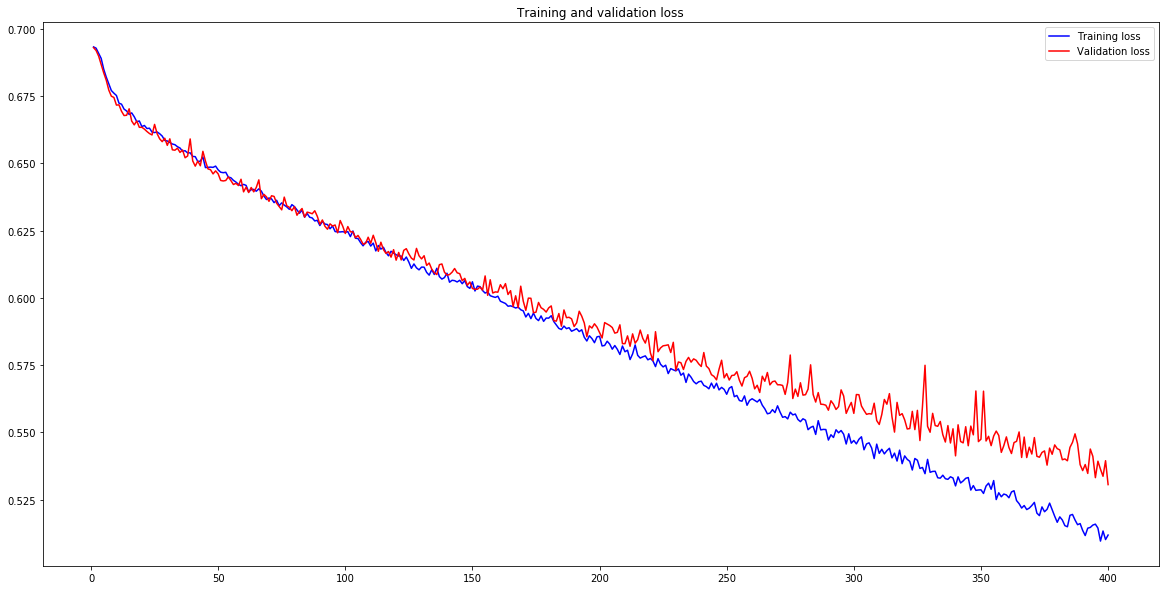

In [33]:
f_acc = func_history.history['acc']
f_val_acc = func_history.history['val_acc']
f_loss = func_history.history['loss']
f_val_loss = func_history.history['val_loss']

epochs = range(1, len(f_acc) + 1)
plt.figure(figsize=(20,10))

plt.plot(epochs, f_acc, 'b', label='Training acc')
plt.plot(epochs, f_val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(20,10))

plt.plot(epochs, f_loss, 'b', label='Training loss')
plt.plot(epochs, f_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()


In [34]:
# *******************
# generate heatmaps
# *******************
from vis.visualization import visualize_cam

In [49]:
img  = np.array(positive_dataset[35])
print(img.shape)

(32, 32, 4)


In [55]:
from vis.utils import utils

In [56]:
last_conv_layer_idx = utils.find_layer_idx(model, 'conv2d_3')

4


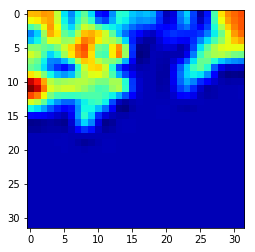

In [63]:
print(last_conv_layer_idx)
heat_map = visualize_cam(model, last_conv_layer_idx, None, img)
plt.imshow(heat_map)
plt.savefig('sample_heatmap.png')

In [ ]:
print(len(positive_dataset))
drawn_heatmap = 0
for i in range(0,len(positive_dataset)):
    img = np.array(positive_dataset[i])
    heat_map = visualize_cam(model, last_conv_layer_idx, None, img)
    
    plt.imshow(heat_map)
    plt.savefig('heatmaps/heatmap_pos_' + str(i) + '.png')
    plt.gcf().clear()
    
    print("Mapped and Drawn: {}".format(i))
    drawn_heatmap += 1

32693
Mapped and Drawn: 940
Mapped and Drawn: 941
Mapped and Drawn: 942
Mapped and Drawn: 943
Mapped and Drawn: 944
Mapped and Drawn: 945
Mapped and Drawn: 946
Mapped and Drawn: 947
Mapped and Drawn: 948
Mapped and Drawn: 949
Mapped and Drawn: 950
Mapped and Drawn: 951
Mapped and Drawn: 952
Mapped and Drawn: 953
Mapped and Drawn: 954
Mapped and Drawn: 955
Mapped and Drawn: 956
Mapped and Drawn: 957
Mapped and Drawn: 958
Mapped and Drawn: 959
Mapped and Drawn: 960
Mapped and Drawn: 961
Mapped and Drawn: 962
Mapped and Drawn: 963
Mapped and Drawn: 964
Mapped and Drawn: 965
Mapped and Drawn: 966
Mapped and Drawn: 967
Mapped and Drawn: 968
Mapped and Drawn: 969
Mapped and Drawn: 970
Mapped and Drawn: 971
Mapped and Drawn: 972
Mapped and Drawn: 973
Mapped and Drawn: 974
Mapped and Drawn: 975
Mapped and Drawn: 976
Mapped and Drawn: 977
Mapped and Drawn: 978
Mapped and Drawn: 979
Mapped and Drawn: 980
Mapped and Drawn: 981
Mapped and Drawn: 982
Mapped and Drawn: 983
Mapped and Drawn: 984
Mapp

Mapped and Drawn: 1299
Mapped and Drawn: 1300
Mapped and Drawn: 1301
Mapped and Drawn: 1302
Mapped and Drawn: 1303
Mapped and Drawn: 1304
Mapped and Drawn: 1305
Mapped and Drawn: 1306
Mapped and Drawn: 1307
Mapped and Drawn: 1308
Mapped and Drawn: 1309
Mapped and Drawn: 1310
Mapped and Drawn: 1311
Mapped and Drawn: 1312
Mapped and Drawn: 1313
Mapped and Drawn: 1314
Mapped and Drawn: 1315
Mapped and Drawn: 1316
Mapped and Drawn: 1317
Mapped and Drawn: 1318
Mapped and Drawn: 1319
Mapped and Drawn: 1320
Mapped and Drawn: 1321
Mapped and Drawn: 1322
Mapped and Drawn: 1323
Mapped and Drawn: 1324
Mapped and Drawn: 1325
Mapped and Drawn: 1326
Mapped and Drawn: 1327
Mapped and Drawn: 1328
Mapped and Drawn: 1329
Mapped and Drawn: 1330
Mapped and Drawn: 1331
Mapped and Drawn: 1332
Mapped and Drawn: 1333
Mapped and Drawn: 1334
Mapped and Drawn: 1335
Mapped and Drawn: 1336
Mapped and Drawn: 1337
Mapped and Drawn: 1338
Mapped and Drawn: 1339
Mapped and Drawn: 1340
Mapped and Drawn: 1341
Mapped and 

Mapped and Drawn: 1656
Mapped and Drawn: 1657
Mapped and Drawn: 1658
Mapped and Drawn: 1659
Mapped and Drawn: 1660
Mapped and Drawn: 1661
Mapped and Drawn: 1662
Mapped and Drawn: 1663
Mapped and Drawn: 1664
Mapped and Drawn: 1665
Mapped and Drawn: 1666
Mapped and Drawn: 1667
Mapped and Drawn: 1668
Mapped and Drawn: 1669
Mapped and Drawn: 1670
Mapped and Drawn: 1671
Mapped and Drawn: 1672
Mapped and Drawn: 1673
Mapped and Drawn: 1674
Mapped and Drawn: 1675
Mapped and Drawn: 1676
Mapped and Drawn: 1677
Mapped and Drawn: 1678
Mapped and Drawn: 1679
Mapped and Drawn: 1680
Mapped and Drawn: 1681
Mapped and Drawn: 1682
Mapped and Drawn: 1683
Mapped and Drawn: 1684
Mapped and Drawn: 1685
Mapped and Drawn: 1686
Mapped and Drawn: 1687
Mapped and Drawn: 1688
Mapped and Drawn: 1689
Mapped and Drawn: 1690
Mapped and Drawn: 1691
Mapped and Drawn: 1692
Mapped and Drawn: 1693
Mapped and Drawn: 1694
Mapped and Drawn: 1695
Mapped and Drawn: 1696
Mapped and Drawn: 1697
Mapped and Drawn: 1698
Mapped and 

Mapped and Drawn: 2013
Mapped and Drawn: 2014
Mapped and Drawn: 2015
Mapped and Drawn: 2016
Mapped and Drawn: 2017
Mapped and Drawn: 2018
Mapped and Drawn: 2019
Mapped and Drawn: 2020
Mapped and Drawn: 2021
Mapped and Drawn: 2022
Mapped and Drawn: 2023
Mapped and Drawn: 2024
Mapped and Drawn: 2025
Mapped and Drawn: 2026
Mapped and Drawn: 2027
Mapped and Drawn: 2028
Mapped and Drawn: 2029
Mapped and Drawn: 2030
Mapped and Drawn: 2031
Mapped and Drawn: 2032
Mapped and Drawn: 2033
Mapped and Drawn: 2034
Mapped and Drawn: 2035
Mapped and Drawn: 2036
Mapped and Drawn: 2037
Mapped and Drawn: 2038
Mapped and Drawn: 2039
Mapped and Drawn: 2040
Mapped and Drawn: 2041
Mapped and Drawn: 2042
Mapped and Drawn: 2043
Mapped and Drawn: 2044
Mapped and Drawn: 2045
Mapped and Drawn: 2046
Mapped and Drawn: 2047
Mapped and Drawn: 2048
Mapped and Drawn: 2049
Mapped and Drawn: 2050
Mapped and Drawn: 2051
Mapped and Drawn: 2052
Mapped and Drawn: 2053
Mapped and Drawn: 2054
Mapped and Drawn: 2055
Mapped and 

Mapped and Drawn: 2370
Mapped and Drawn: 2371
Mapped and Drawn: 2372
Mapped and Drawn: 2373
Mapped and Drawn: 2374
Mapped and Drawn: 2375
Mapped and Drawn: 2376
Mapped and Drawn: 2377
Mapped and Drawn: 2378
Mapped and Drawn: 2379
Mapped and Drawn: 2380
Mapped and Drawn: 2381
Mapped and Drawn: 2382
Mapped and Drawn: 2383
Mapped and Drawn: 2384
Mapped and Drawn: 2385
Mapped and Drawn: 2386
Mapped and Drawn: 2387
Mapped and Drawn: 2388
Mapped and Drawn: 2389
Mapped and Drawn: 2390
Mapped and Drawn: 2391
Mapped and Drawn: 2392
Mapped and Drawn: 2393
Mapped and Drawn: 2394
Mapped and Drawn: 2395
Mapped and Drawn: 2396
Mapped and Drawn: 2397
Mapped and Drawn: 2398
Mapped and Drawn: 2399
Mapped and Drawn: 2400
Mapped and Drawn: 2401
Mapped and Drawn: 2402
Mapped and Drawn: 2403
Mapped and Drawn: 2404
Mapped and Drawn: 2405
Mapped and Drawn: 2406
Mapped and Drawn: 2407
Mapped and Drawn: 2408
Mapped and Drawn: 2409
Mapped and Drawn: 2410
Mapped and Drawn: 2411
Mapped and Drawn: 2412
Mapped and 

Mapped and Drawn: 2727
Mapped and Drawn: 2728
Mapped and Drawn: 2729
Mapped and Drawn: 2730
Mapped and Drawn: 2731
Mapped and Drawn: 2732
Mapped and Drawn: 2733
Mapped and Drawn: 2734
Mapped and Drawn: 2735
Mapped and Drawn: 2736
Mapped and Drawn: 2737
Mapped and Drawn: 2738
Mapped and Drawn: 2739
Mapped and Drawn: 2740
Mapped and Drawn: 2741
Mapped and Drawn: 2742
Mapped and Drawn: 2743
Mapped and Drawn: 2744
Mapped and Drawn: 2745
Mapped and Drawn: 2746
Mapped and Drawn: 2747
Mapped and Drawn: 2748
Mapped and Drawn: 2749
Mapped and Drawn: 2750
Mapped and Drawn: 2751
Mapped and Drawn: 2752
Mapped and Drawn: 2753
Mapped and Drawn: 2754
Mapped and Drawn: 2755
Mapped and Drawn: 2756
Mapped and Drawn: 2757
Mapped and Drawn: 2758
Mapped and Drawn: 2759
Mapped and Drawn: 2760
Mapped and Drawn: 2761
Mapped and Drawn: 2762
Mapped and Drawn: 2763
Mapped and Drawn: 2764
Mapped and Drawn: 2765
Mapped and Drawn: 2766
Mapped and Drawn: 2767
Mapped and Drawn: 2768
Mapped and Drawn: 2769
Mapped and 

Mapped and Drawn: 3084
Mapped and Drawn: 3085
Mapped and Drawn: 3086
Mapped and Drawn: 3087
Mapped and Drawn: 3088
Mapped and Drawn: 3089
Mapped and Drawn: 3090
Mapped and Drawn: 3091
Mapped and Drawn: 3092
Mapped and Drawn: 3093
Mapped and Drawn: 3094
Mapped and Drawn: 3095
Mapped and Drawn: 3096
Mapped and Drawn: 3097
Mapped and Drawn: 3098
Mapped and Drawn: 3099
Mapped and Drawn: 3100
Mapped and Drawn: 3101
Mapped and Drawn: 3102
Mapped and Drawn: 3103
Mapped and Drawn: 3104
Mapped and Drawn: 3105
Mapped and Drawn: 3106
Mapped and Drawn: 3107
Mapped and Drawn: 3108
Mapped and Drawn: 3109
Mapped and Drawn: 3110
Mapped and Drawn: 3111
Mapped and Drawn: 3112
Mapped and Drawn: 3113
Mapped and Drawn: 3114
Mapped and Drawn: 3115
Mapped and Drawn: 3116
Mapped and Drawn: 3117
Mapped and Drawn: 3118
Mapped and Drawn: 3119
Mapped and Drawn: 3120
Mapped and Drawn: 3121
Mapped and Drawn: 3122
Mapped and Drawn: 3123
Mapped and Drawn: 3124
Mapped and Drawn: 3125
Mapped and Drawn: 3126
Mapped and 

Mapped and Drawn: 3441
Mapped and Drawn: 3442
Mapped and Drawn: 3443
Mapped and Drawn: 3444
Mapped and Drawn: 3445
Mapped and Drawn: 3446
Mapped and Drawn: 3447
Mapped and Drawn: 3448
Mapped and Drawn: 3449
Mapped and Drawn: 3450
Mapped and Drawn: 3451
Mapped and Drawn: 3452
Mapped and Drawn: 3453
Mapped and Drawn: 3454
Mapped and Drawn: 3455
Mapped and Drawn: 3456
Mapped and Drawn: 3457
Mapped and Drawn: 3458
Mapped and Drawn: 3459
Mapped and Drawn: 3460
Mapped and Drawn: 3461
Mapped and Drawn: 3462
Mapped and Drawn: 3463
Mapped and Drawn: 3464
Mapped and Drawn: 3465
Mapped and Drawn: 3466
Mapped and Drawn: 3467
Mapped and Drawn: 3468
Mapped and Drawn: 3469
Mapped and Drawn: 3470
Mapped and Drawn: 3471
Mapped and Drawn: 3472
Mapped and Drawn: 3473
Mapped and Drawn: 3474
Mapped and Drawn: 3475
Mapped and Drawn: 3476
Mapped and Drawn: 3477
Mapped and Drawn: 3478
Mapped and Drawn: 3479
Mapped and Drawn: 3480
Mapped and Drawn: 3481
Mapped and Drawn: 3482
Mapped and Drawn: 3483
Mapped and 

Mapped and Drawn: 3798
Mapped and Drawn: 3799
Mapped and Drawn: 3800
Mapped and Drawn: 3801
Mapped and Drawn: 3802
Mapped and Drawn: 3803
Mapped and Drawn: 3804
Mapped and Drawn: 3805
Mapped and Drawn: 3806
Mapped and Drawn: 3807
Mapped and Drawn: 3808
Mapped and Drawn: 3809
Mapped and Drawn: 3810
Mapped and Drawn: 3811
Mapped and Drawn: 3812
Mapped and Drawn: 3813
Mapped and Drawn: 3814
Mapped and Drawn: 3815
Mapped and Drawn: 3816
Mapped and Drawn: 3817
Mapped and Drawn: 3818
Mapped and Drawn: 3819
Mapped and Drawn: 3820
Mapped and Drawn: 3821
Mapped and Drawn: 3822
Mapped and Drawn: 3823
Mapped and Drawn: 3824
Mapped and Drawn: 3825
Mapped and Drawn: 3826
Mapped and Drawn: 3827
Mapped and Drawn: 3828
Mapped and Drawn: 3829
Mapped and Drawn: 3830
Mapped and Drawn: 3831
Mapped and Drawn: 3832
Mapped and Drawn: 3833
Mapped and Drawn: 3834
Mapped and Drawn: 3835
Mapped and Drawn: 3836
Mapped and Drawn: 3837
Mapped and Drawn: 3838
Mapped and Drawn: 3839
Mapped and Drawn: 3840
Mapped and 

Mapped and Drawn: 4155
Mapped and Drawn: 4156
Mapped and Drawn: 4157
Mapped and Drawn: 4158
Mapped and Drawn: 4159
Mapped and Drawn: 4160
Mapped and Drawn: 4161
Mapped and Drawn: 4162
Mapped and Drawn: 4163
Mapped and Drawn: 4164
Mapped and Drawn: 4165
Mapped and Drawn: 4166
Mapped and Drawn: 4167
Mapped and Drawn: 4168
Mapped and Drawn: 4169
Mapped and Drawn: 4170
Mapped and Drawn: 4171
Mapped and Drawn: 4172
Mapped and Drawn: 4173
Mapped and Drawn: 4174
Mapped and Drawn: 4175
Mapped and Drawn: 4176
Mapped and Drawn: 4177
Mapped and Drawn: 4178
Mapped and Drawn: 4179
Mapped and Drawn: 4180
Mapped and Drawn: 4181
Mapped and Drawn: 4182
Mapped and Drawn: 4183
Mapped and Drawn: 4184
Mapped and Drawn: 4185
Mapped and Drawn: 4186
Mapped and Drawn: 4187
Mapped and Drawn: 4188
Mapped and Drawn: 4189
Mapped and Drawn: 4190
Mapped and Drawn: 4191
Mapped and Drawn: 4192
Mapped and Drawn: 4193
Mapped and Drawn: 4194
Mapped and Drawn: 4195
Mapped and Drawn: 4196
Mapped and Drawn: 4197
Mapped and 

Mapped and Drawn: 4512
Mapped and Drawn: 4513
Mapped and Drawn: 4514
Mapped and Drawn: 4515
Mapped and Drawn: 4516
Mapped and Drawn: 4517
Mapped and Drawn: 4518
Mapped and Drawn: 4519
Mapped and Drawn: 4520
Mapped and Drawn: 4521
Mapped and Drawn: 4522
Mapped and Drawn: 4523
Mapped and Drawn: 4524
Mapped and Drawn: 4525
Mapped and Drawn: 4526
Mapped and Drawn: 4527
Mapped and Drawn: 4528
Mapped and Drawn: 4529
Mapped and Drawn: 4530
Mapped and Drawn: 4531
Mapped and Drawn: 4532
Mapped and Drawn: 4533
Mapped and Drawn: 4534
Mapped and Drawn: 4535
Mapped and Drawn: 4536
Mapped and Drawn: 4537
Mapped and Drawn: 4538
Mapped and Drawn: 4539
Mapped and Drawn: 4540
Mapped and Drawn: 4541
Mapped and Drawn: 4542
Mapped and Drawn: 4543
Mapped and Drawn: 4544
Mapped and Drawn: 4545
Mapped and Drawn: 4546
Mapped and Drawn: 4547
Mapped and Drawn: 4548
Mapped and Drawn: 4549
Mapped and Drawn: 4550
Mapped and Drawn: 4551
Mapped and Drawn: 4552
Mapped and Drawn: 4553
Mapped and Drawn: 4554
Mapped and 

Mapped and Drawn: 4869
Mapped and Drawn: 4870
Mapped and Drawn: 4871
Mapped and Drawn: 4872
Mapped and Drawn: 4873
Mapped and Drawn: 4874
Mapped and Drawn: 4875
Mapped and Drawn: 4876
Mapped and Drawn: 4877
Mapped and Drawn: 4878
Mapped and Drawn: 4879
Mapped and Drawn: 4880
Mapped and Drawn: 4881
Mapped and Drawn: 4882
Mapped and Drawn: 4883
Mapped and Drawn: 4884
Mapped and Drawn: 4885
Mapped and Drawn: 4886
Mapped and Drawn: 4887
Mapped and Drawn: 4888
Mapped and Drawn: 4889
Mapped and Drawn: 4890
Mapped and Drawn: 4891
Mapped and Drawn: 4892
Mapped and Drawn: 4893
Mapped and Drawn: 4894
Mapped and Drawn: 4895
Mapped and Drawn: 4896
Mapped and Drawn: 4897
Mapped and Drawn: 4898
Mapped and Drawn: 4899
Mapped and Drawn: 4900
Mapped and Drawn: 4901
Mapped and Drawn: 4902
Mapped and Drawn: 4903
Mapped and Drawn: 4904
Mapped and Drawn: 4905
Mapped and Drawn: 4906
Mapped and Drawn: 4907
Mapped and Drawn: 4908
Mapped and Drawn: 4909
Mapped and Drawn: 4910
Mapped and Drawn: 4911
Mapped and 

Mapped and Drawn: 5226
Mapped and Drawn: 5227
Mapped and Drawn: 5228
Mapped and Drawn: 5229
Mapped and Drawn: 5230
Mapped and Drawn: 5231
Mapped and Drawn: 5232
Mapped and Drawn: 5233
Mapped and Drawn: 5234
Mapped and Drawn: 5235
Mapped and Drawn: 5236
Mapped and Drawn: 5237
Mapped and Drawn: 5238
Mapped and Drawn: 5239
Mapped and Drawn: 5240
Mapped and Drawn: 5241
Mapped and Drawn: 5242
Mapped and Drawn: 5243
Mapped and Drawn: 5244
Mapped and Drawn: 5245
Mapped and Drawn: 5246
Mapped and Drawn: 5247
Mapped and Drawn: 5248
Mapped and Drawn: 5249
Mapped and Drawn: 5250
Mapped and Drawn: 5251
Mapped and Drawn: 5252
Mapped and Drawn: 5253
Mapped and Drawn: 5254
Mapped and Drawn: 5255
Mapped and Drawn: 5256
Mapped and Drawn: 5257
Mapped and Drawn: 5258
Mapped and Drawn: 5259
Mapped and Drawn: 5260
Mapped and Drawn: 5261
Mapped and Drawn: 5262
Mapped and Drawn: 5263
Mapped and Drawn: 5264
Mapped and Drawn: 5265
Mapped and Drawn: 5266
Mapped and Drawn: 5267
Mapped and Drawn: 5268
Mapped and 

Mapped and Drawn: 5583
Mapped and Drawn: 5584
Mapped and Drawn: 5585
Mapped and Drawn: 5586
Mapped and Drawn: 5587
Mapped and Drawn: 5588
Mapped and Drawn: 5589
Mapped and Drawn: 5590
Mapped and Drawn: 5591
Mapped and Drawn: 5592
Mapped and Drawn: 5593
Mapped and Drawn: 5594
Mapped and Drawn: 5595
Mapped and Drawn: 5596
Mapped and Drawn: 5597
Mapped and Drawn: 5598
Mapped and Drawn: 5599
Mapped and Drawn: 5600
Mapped and Drawn: 5601
Mapped and Drawn: 5602
Mapped and Drawn: 5603
Mapped and Drawn: 5604
Mapped and Drawn: 5605
Mapped and Drawn: 5606
Mapped and Drawn: 5607
Mapped and Drawn: 5608
Mapped and Drawn: 5609
Mapped and Drawn: 5610
Mapped and Drawn: 5611
Mapped and Drawn: 5612
Mapped and Drawn: 5613
Mapped and Drawn: 5614
Mapped and Drawn: 5615
Mapped and Drawn: 5616
Mapped and Drawn: 5617
Mapped and Drawn: 5618
Mapped and Drawn: 5619
Mapped and Drawn: 5620
Mapped and Drawn: 5621
Mapped and Drawn: 5622
Mapped and Drawn: 5623
Mapped and Drawn: 5624
Mapped and Drawn: 5625
Mapped and 

Mapped and Drawn: 5940
Mapped and Drawn: 5941
Mapped and Drawn: 5942
Mapped and Drawn: 5943
Mapped and Drawn: 5944
Mapped and Drawn: 5945
Mapped and Drawn: 5946
Mapped and Drawn: 5947
Mapped and Drawn: 5948
Mapped and Drawn: 5949
Mapped and Drawn: 5950
Mapped and Drawn: 5951
Mapped and Drawn: 5952
Mapped and Drawn: 5953
Mapped and Drawn: 5954
Mapped and Drawn: 5955
Mapped and Drawn: 5956
Mapped and Drawn: 5957
Mapped and Drawn: 5958
Mapped and Drawn: 5959
Mapped and Drawn: 5960
Mapped and Drawn: 5961
Mapped and Drawn: 5962
Mapped and Drawn: 5963
Mapped and Drawn: 5964
Mapped and Drawn: 5965
Mapped and Drawn: 5966
Mapped and Drawn: 5967
Mapped and Drawn: 5968
Mapped and Drawn: 5969
Mapped and Drawn: 5970
Mapped and Drawn: 5971
Mapped and Drawn: 5972
Mapped and Drawn: 5973
Mapped and Drawn: 5974
Mapped and Drawn: 5975
Mapped and Drawn: 5976
Mapped and Drawn: 5977
Mapped and Drawn: 5978
Mapped and Drawn: 5979
Mapped and Drawn: 5980
Mapped and Drawn: 5981
Mapped and Drawn: 5982
Mapped and 

Mapped and Drawn: 6297
Mapped and Drawn: 6298
Mapped and Drawn: 6299
Mapped and Drawn: 6300
Mapped and Drawn: 6301
Mapped and Drawn: 6302
Mapped and Drawn: 6303
Mapped and Drawn: 6304
Mapped and Drawn: 6305
Mapped and Drawn: 6306
Mapped and Drawn: 6307
Mapped and Drawn: 6308
Mapped and Drawn: 6309
Mapped and Drawn: 6310
Mapped and Drawn: 6311
Mapped and Drawn: 6312
Mapped and Drawn: 6313
Mapped and Drawn: 6314
Mapped and Drawn: 6315
Mapped and Drawn: 6316
Mapped and Drawn: 6317
Mapped and Drawn: 6318
Mapped and Drawn: 6319
Mapped and Drawn: 6320
Mapped and Drawn: 6321
Mapped and Drawn: 6322
Mapped and Drawn: 6323
Mapped and Drawn: 6324
Mapped and Drawn: 6325
Mapped and Drawn: 6326
Mapped and Drawn: 6327
Mapped and Drawn: 6328
Mapped and Drawn: 6329
Mapped and Drawn: 6330
Mapped and Drawn: 6331
Mapped and Drawn: 6332
Mapped and Drawn: 6333
Mapped and Drawn: 6334
Mapped and Drawn: 6335
Mapped and Drawn: 6336
Mapped and Drawn: 6337
Mapped and Drawn: 6338
Mapped and Drawn: 6339
Mapped and 

Mapped and Drawn: 6654
Mapped and Drawn: 6655
Mapped and Drawn: 6656
Mapped and Drawn: 6657
Mapped and Drawn: 6658
Mapped and Drawn: 6659
Mapped and Drawn: 6660
Mapped and Drawn: 6661
Mapped and Drawn: 6662
Mapped and Drawn: 6663
Mapped and Drawn: 6664
Mapped and Drawn: 6665
Mapped and Drawn: 6666
Mapped and Drawn: 6667
Mapped and Drawn: 6668
Mapped and Drawn: 6669
Mapped and Drawn: 6670
Mapped and Drawn: 6671
Mapped and Drawn: 6672
Mapped and Drawn: 6673
Mapped and Drawn: 6674
Mapped and Drawn: 6675
Mapped and Drawn: 6676
Mapped and Drawn: 6677
Mapped and Drawn: 6678
Mapped and Drawn: 6679
Mapped and Drawn: 6680
Mapped and Drawn: 6681
Mapped and Drawn: 6682
Mapped and Drawn: 6683
Mapped and Drawn: 6684
Mapped and Drawn: 6685
Mapped and Drawn: 6686
Mapped and Drawn: 6687
Mapped and Drawn: 6688
Mapped and Drawn: 6689
Mapped and Drawn: 6690
Mapped and Drawn: 6691
Mapped and Drawn: 6692
Mapped and Drawn: 6693
Mapped and Drawn: 6694
Mapped and Drawn: 6695
Mapped and Drawn: 6696
Mapped and 

Mapped and Drawn: 7011
Mapped and Drawn: 7012
Mapped and Drawn: 7013
Mapped and Drawn: 7014
Mapped and Drawn: 7015
Mapped and Drawn: 7016
Mapped and Drawn: 7017
Mapped and Drawn: 7018
Mapped and Drawn: 7019
Mapped and Drawn: 7020
Mapped and Drawn: 7021
Mapped and Drawn: 7022
Mapped and Drawn: 7023
Mapped and Drawn: 7024
Mapped and Drawn: 7025
Mapped and Drawn: 7026
Mapped and Drawn: 7027
Mapped and Drawn: 7028
Mapped and Drawn: 7029
Mapped and Drawn: 7030
Mapped and Drawn: 7031
Mapped and Drawn: 7032
Mapped and Drawn: 7033
Mapped and Drawn: 7034
Mapped and Drawn: 7035
Mapped and Drawn: 7036
Mapped and Drawn: 7037
Mapped and Drawn: 7038
Mapped and Drawn: 7039
Mapped and Drawn: 7040
Mapped and Drawn: 7041
Mapped and Drawn: 7042
Mapped and Drawn: 7043
Mapped and Drawn: 7044
Mapped and Drawn: 7045
Mapped and Drawn: 7046
Mapped and Drawn: 7047
Mapped and Drawn: 7048
Mapped and Drawn: 7049
Mapped and Drawn: 7050
Mapped and Drawn: 7051
Mapped and Drawn: 7052
Mapped and Drawn: 7053
Mapped and 

Mapped and Drawn: 7368
Mapped and Drawn: 7369
Mapped and Drawn: 7370
Mapped and Drawn: 7371
Mapped and Drawn: 7372
Mapped and Drawn: 7373
Mapped and Drawn: 7374
Mapped and Drawn: 7375
Mapped and Drawn: 7376
Mapped and Drawn: 7377
Mapped and Drawn: 7378
Mapped and Drawn: 7379
Mapped and Drawn: 7380
Mapped and Drawn: 7381
Mapped and Drawn: 7382
Mapped and Drawn: 7383
Mapped and Drawn: 7384
Mapped and Drawn: 7385
Mapped and Drawn: 7386
Mapped and Drawn: 7387
Mapped and Drawn: 7388
Mapped and Drawn: 7389
Mapped and Drawn: 7390
Mapped and Drawn: 7391
Mapped and Drawn: 7392
Mapped and Drawn: 7393
Mapped and Drawn: 7394
Mapped and Drawn: 7395
Mapped and Drawn: 7396
Mapped and Drawn: 7397
Mapped and Drawn: 7398
Mapped and Drawn: 7399
Mapped and Drawn: 7400
Mapped and Drawn: 7401
Mapped and Drawn: 7402
Mapped and Drawn: 7403
Mapped and Drawn: 7404
Mapped and Drawn: 7405
Mapped and Drawn: 7406
Mapped and Drawn: 7407
Mapped and Drawn: 7408
Mapped and Drawn: 7409
Mapped and Drawn: 7410
Mapped and 

Mapped and Drawn: 7725
Mapped and Drawn: 7726
Mapped and Drawn: 7727
Mapped and Drawn: 7728
Mapped and Drawn: 7729
Mapped and Drawn: 7730
Mapped and Drawn: 7731
Mapped and Drawn: 7732
Mapped and Drawn: 7733
Mapped and Drawn: 7734
Mapped and Drawn: 7735
Mapped and Drawn: 7736
Mapped and Drawn: 7737
Mapped and Drawn: 7738
Mapped and Drawn: 7739
Mapped and Drawn: 7740
Mapped and Drawn: 7741
Mapped and Drawn: 7742
Mapped and Drawn: 7743
Mapped and Drawn: 7744
Mapped and Drawn: 7745
Mapped and Drawn: 7746
Mapped and Drawn: 7747
Mapped and Drawn: 7748
Mapped and Drawn: 7749
Mapped and Drawn: 7750
Mapped and Drawn: 7751
Mapped and Drawn: 7752
Mapped and Drawn: 7753
Mapped and Drawn: 7754
Mapped and Drawn: 7755
Mapped and Drawn: 7756
Mapped and Drawn: 7757
Mapped and Drawn: 7758
Mapped and Drawn: 7759
Mapped and Drawn: 7760
Mapped and Drawn: 7761
Mapped and Drawn: 7762
Mapped and Drawn: 7763
Mapped and Drawn: 7764
Mapped and Drawn: 7765
Mapped and Drawn: 7766
Mapped and Drawn: 7767
Mapped and 

Mapped and Drawn: 8082
Mapped and Drawn: 8083
Mapped and Drawn: 8084
Mapped and Drawn: 8085
Mapped and Drawn: 8086
Mapped and Drawn: 8087
Mapped and Drawn: 8088
Mapped and Drawn: 8089
Mapped and Drawn: 8090
Mapped and Drawn: 8091
Mapped and Drawn: 8092
Mapped and Drawn: 8093
Mapped and Drawn: 8094
Mapped and Drawn: 8095
Mapped and Drawn: 8096
Mapped and Drawn: 8097
Mapped and Drawn: 8098
Mapped and Drawn: 8099
Mapped and Drawn: 8100
Mapped and Drawn: 8101
Mapped and Drawn: 8102
Mapped and Drawn: 8103
Mapped and Drawn: 8104
Mapped and Drawn: 8105
Mapped and Drawn: 8106
Mapped and Drawn: 8107
Mapped and Drawn: 8108
Mapped and Drawn: 8109
Mapped and Drawn: 8110
Mapped and Drawn: 8111
Mapped and Drawn: 8112
Mapped and Drawn: 8113
Mapped and Drawn: 8114
Mapped and Drawn: 8115
Mapped and Drawn: 8116
Mapped and Drawn: 8117
Mapped and Drawn: 8118
Mapped and Drawn: 8119
Mapped and Drawn: 8120
Mapped and Drawn: 8121
Mapped and Drawn: 8122
Mapped and Drawn: 8123
Mapped and Drawn: 8124
Mapped and 

Mapped and Drawn: 8439
Mapped and Drawn: 8440
Mapped and Drawn: 8441
Mapped and Drawn: 8442
Mapped and Drawn: 8443
Mapped and Drawn: 8444
Mapped and Drawn: 8445
Mapped and Drawn: 8446
Mapped and Drawn: 8447
Mapped and Drawn: 8448
Mapped and Drawn: 8449
Mapped and Drawn: 8450
Mapped and Drawn: 8451
Mapped and Drawn: 8452
Mapped and Drawn: 8453
Mapped and Drawn: 8454
Mapped and Drawn: 8455
Mapped and Drawn: 8456
Mapped and Drawn: 8457
Mapped and Drawn: 8458
Mapped and Drawn: 8459
Mapped and Drawn: 8460
Mapped and Drawn: 8461
Mapped and Drawn: 8462
Mapped and Drawn: 8463
Mapped and Drawn: 8464
Mapped and Drawn: 8465
Mapped and Drawn: 8466
Mapped and Drawn: 8467
Mapped and Drawn: 8468
Mapped and Drawn: 8469
Mapped and Drawn: 8470
Mapped and Drawn: 8471
Mapped and Drawn: 8472
Mapped and Drawn: 8473
Mapped and Drawn: 8474
Mapped and Drawn: 8475
Mapped and Drawn: 8476
Mapped and Drawn: 8477
Mapped and Drawn: 8478
Mapped and Drawn: 8479
Mapped and Drawn: 8480
Mapped and Drawn: 8481
Mapped and 

Mapped and Drawn: 8796
Mapped and Drawn: 8797
Mapped and Drawn: 8798
Mapped and Drawn: 8799
Mapped and Drawn: 8800
Mapped and Drawn: 8801
Mapped and Drawn: 8802
Mapped and Drawn: 8803
Mapped and Drawn: 8804
Mapped and Drawn: 8805
Mapped and Drawn: 8806
Mapped and Drawn: 8807
Mapped and Drawn: 8808
Mapped and Drawn: 8809
Mapped and Drawn: 8810
Mapped and Drawn: 8811
Mapped and Drawn: 8812
Mapped and Drawn: 8813
Mapped and Drawn: 8814
Mapped and Drawn: 8815
Mapped and Drawn: 8816
Mapped and Drawn: 8817
Mapped and Drawn: 8818
Mapped and Drawn: 8819
Mapped and Drawn: 8820
Mapped and Drawn: 8821
Mapped and Drawn: 8822
Mapped and Drawn: 8823
Mapped and Drawn: 8824
Mapped and Drawn: 8825
Mapped and Drawn: 8826
Mapped and Drawn: 8827
Mapped and Drawn: 8828
Mapped and Drawn: 8829
Mapped and Drawn: 8830
Mapped and Drawn: 8831
Mapped and Drawn: 8832
Mapped and Drawn: 8833
Mapped and Drawn: 8834
Mapped and Drawn: 8835
Mapped and Drawn: 8836
Mapped and Drawn: 8837
Mapped and Drawn: 8838
Mapped and 

Mapped and Drawn: 9153
Mapped and Drawn: 9154
Mapped and Drawn: 9155
Mapped and Drawn: 9156
Mapped and Drawn: 9157
Mapped and Drawn: 9158
Mapped and Drawn: 9159
Mapped and Drawn: 9160
Mapped and Drawn: 9161
Mapped and Drawn: 9162
Mapped and Drawn: 9163
Mapped and Drawn: 9164
Mapped and Drawn: 9165
Mapped and Drawn: 9166
Mapped and Drawn: 9167
Mapped and Drawn: 9168
Mapped and Drawn: 9169
Mapped and Drawn: 9170
Mapped and Drawn: 9171
Mapped and Drawn: 9172
Mapped and Drawn: 9173
Mapped and Drawn: 9174
Mapped and Drawn: 9175
Mapped and Drawn: 9176
Mapped and Drawn: 9177
Mapped and Drawn: 9178
Mapped and Drawn: 9179
Mapped and Drawn: 9180
Mapped and Drawn: 9181
Mapped and Drawn: 9182
Mapped and Drawn: 9183
Mapped and Drawn: 9184
Mapped and Drawn: 9185
Mapped and Drawn: 9186
Mapped and Drawn: 9187
Mapped and Drawn: 9188
Mapped and Drawn: 9189
Mapped and Drawn: 9190
Mapped and Drawn: 9191
Mapped and Drawn: 9192
Mapped and Drawn: 9193
Mapped and Drawn: 9194
Mapped and Drawn: 9195
Mapped and 

Mapped and Drawn: 9510
Mapped and Drawn: 9511
Mapped and Drawn: 9512
Mapped and Drawn: 9513
Mapped and Drawn: 9514
Mapped and Drawn: 9515
Mapped and Drawn: 9516
Mapped and Drawn: 9517
Mapped and Drawn: 9518
Mapped and Drawn: 9519
Mapped and Drawn: 9520
Mapped and Drawn: 9521
Mapped and Drawn: 9522
Mapped and Drawn: 9523
Mapped and Drawn: 9524
Mapped and Drawn: 9525
Mapped and Drawn: 9526
Mapped and Drawn: 9527
Mapped and Drawn: 9528
Mapped and Drawn: 9529
Mapped and Drawn: 9530
Mapped and Drawn: 9531
Mapped and Drawn: 9532
Mapped and Drawn: 9533
Mapped and Drawn: 9534
Mapped and Drawn: 9535
Mapped and Drawn: 9536
Mapped and Drawn: 9537
Mapped and Drawn: 9538
Mapped and Drawn: 9539
Mapped and Drawn: 9540
Mapped and Drawn: 9541
Mapped and Drawn: 9542
Mapped and Drawn: 9543
Mapped and Drawn: 9544
Mapped and Drawn: 9545
Mapped and Drawn: 9546
Mapped and Drawn: 9547
Mapped and Drawn: 9548
Mapped and Drawn: 9549
Mapped and Drawn: 9550
Mapped and Drawn: 9551
Mapped and Drawn: 9552
Mapped and 

Mapped and Drawn: 9867
Mapped and Drawn: 9868
Mapped and Drawn: 9869
Mapped and Drawn: 9870
Mapped and Drawn: 9871
Mapped and Drawn: 9872
Mapped and Drawn: 9873
Mapped and Drawn: 9874
Mapped and Drawn: 9875
Mapped and Drawn: 9876
Mapped and Drawn: 9877
Mapped and Drawn: 9878
Mapped and Drawn: 9879
Mapped and Drawn: 9880
Mapped and Drawn: 9881
Mapped and Drawn: 9882
Mapped and Drawn: 9883
Mapped and Drawn: 9884
Mapped and Drawn: 9885
Mapped and Drawn: 9886
Mapped and Drawn: 9887
Mapped and Drawn: 9888
Mapped and Drawn: 9889
Mapped and Drawn: 9890
Mapped and Drawn: 9891
Mapped and Drawn: 9892
Mapped and Drawn: 9893
Mapped and Drawn: 9894
Mapped and Drawn: 9895
Mapped and Drawn: 9896
Mapped and Drawn: 9897
Mapped and Drawn: 9898
Mapped and Drawn: 9899
Mapped and Drawn: 9900
Mapped and Drawn: 9901
Mapped and Drawn: 9902
Mapped and Drawn: 9903
Mapped and Drawn: 9904
Mapped and Drawn: 9905
Mapped and Drawn: 9906
Mapped and Drawn: 9907
Mapped and Drawn: 9908
Mapped and Drawn: 9909
Mapped and 

Mapped and Drawn: 10214
Mapped and Drawn: 10215
Mapped and Drawn: 10216
Mapped and Drawn: 10217
Mapped and Drawn: 10218
Mapped and Drawn: 10219
Mapped and Drawn: 10220
Mapped and Drawn: 10221
Mapped and Drawn: 10222
Mapped and Drawn: 10223
Mapped and Drawn: 10224
Mapped and Drawn: 10225
Mapped and Drawn: 10226
Mapped and Drawn: 10227
Mapped and Drawn: 10228
Mapped and Drawn: 10229
Mapped and Drawn: 10230
Mapped and Drawn: 10231
Mapped and Drawn: 10232
Mapped and Drawn: 10233
Mapped and Drawn: 10234
Mapped and Drawn: 10235
Mapped and Drawn: 10236
Mapped and Drawn: 10237
Mapped and Drawn: 10238
Mapped and Drawn: 10239
Mapped and Drawn: 10240
Mapped and Drawn: 10241
Mapped and Drawn: 10242
Mapped and Drawn: 10243
Mapped and Drawn: 10244
Mapped and Drawn: 10245
Mapped and Drawn: 10246
Mapped and Drawn: 10247
Mapped and Drawn: 10248
Mapped and Drawn: 10249
Mapped and Drawn: 10250
Mapped and Drawn: 10251
Mapped and Drawn: 10252
Mapped and Drawn: 10253
Mapped and Drawn: 10254
Mapped and Drawn

Mapped and Drawn: 10556
Mapped and Drawn: 10557
Mapped and Drawn: 10558
Mapped and Drawn: 10559
Mapped and Drawn: 10560
Mapped and Drawn: 10561
Mapped and Drawn: 10562
Mapped and Drawn: 10563
Mapped and Drawn: 10564
Mapped and Drawn: 10565
Mapped and Drawn: 10566
Mapped and Drawn: 10567
Mapped and Drawn: 10568
Mapped and Drawn: 10569
Mapped and Drawn: 10570
Mapped and Drawn: 10571
Mapped and Drawn: 10572
Mapped and Drawn: 10573
Mapped and Drawn: 10574
Mapped and Drawn: 10575
Mapped and Drawn: 10576
Mapped and Drawn: 10577
Mapped and Drawn: 10578
Mapped and Drawn: 10579
Mapped and Drawn: 10580
Mapped and Drawn: 10581
Mapped and Drawn: 10582
Mapped and Drawn: 10583
Mapped and Drawn: 10584
Mapped and Drawn: 10585
Mapped and Drawn: 10586
Mapped and Drawn: 10587
Mapped and Drawn: 10588
Mapped and Drawn: 10589
Mapped and Drawn: 10590
Mapped and Drawn: 10591
Mapped and Drawn: 10592
Mapped and Drawn: 10593
Mapped and Drawn: 10594
Mapped and Drawn: 10595
Mapped and Drawn: 10596
Mapped and Drawn

Mapped and Drawn: 10898
Mapped and Drawn: 10899
Mapped and Drawn: 10900
Mapped and Drawn: 10901
Mapped and Drawn: 10902
Mapped and Drawn: 10903
Mapped and Drawn: 10904
Mapped and Drawn: 10905
Mapped and Drawn: 10906
Mapped and Drawn: 10907
Mapped and Drawn: 10908
Mapped and Drawn: 10909
Mapped and Drawn: 10910
Mapped and Drawn: 10911
Mapped and Drawn: 10912
Mapped and Drawn: 10913
Mapped and Drawn: 10914
Mapped and Drawn: 10915
Mapped and Drawn: 10916
Mapped and Drawn: 10917
Mapped and Drawn: 10918
Mapped and Drawn: 10919
Mapped and Drawn: 10920
Mapped and Drawn: 10921
Mapped and Drawn: 10922
Mapped and Drawn: 10923
Mapped and Drawn: 10924
Mapped and Drawn: 10925
Mapped and Drawn: 10926
Mapped and Drawn: 10927
Mapped and Drawn: 10928
Mapped and Drawn: 10929
Mapped and Drawn: 10930
Mapped and Drawn: 10931
Mapped and Drawn: 10932
Mapped and Drawn: 10933
Mapped and Drawn: 10934
Mapped and Drawn: 10935
Mapped and Drawn: 10936
Mapped and Drawn: 10937
Mapped and Drawn: 10938
Mapped and Drawn

Mapped and Drawn: 11240
Mapped and Drawn: 11241
Mapped and Drawn: 11242
Mapped and Drawn: 11243
Mapped and Drawn: 11244
Mapped and Drawn: 11245
Mapped and Drawn: 11246
Mapped and Drawn: 11247
Mapped and Drawn: 11248
Mapped and Drawn: 11249
Mapped and Drawn: 11250
Mapped and Drawn: 11251
Mapped and Drawn: 11252
Mapped and Drawn: 11253
Mapped and Drawn: 11254
Mapped and Drawn: 11255
Mapped and Drawn: 11256
Mapped and Drawn: 11257
Mapped and Drawn: 11258
Mapped and Drawn: 11259
Mapped and Drawn: 11260
Mapped and Drawn: 11261
Mapped and Drawn: 11262
Mapped and Drawn: 11263
Mapped and Drawn: 11264
Mapped and Drawn: 11265
Mapped and Drawn: 11266
Mapped and Drawn: 11267
Mapped and Drawn: 11268
Mapped and Drawn: 11269
Mapped and Drawn: 11270
Mapped and Drawn: 11271
Mapped and Drawn: 11272
Mapped and Drawn: 11273
Mapped and Drawn: 11274
Mapped and Drawn: 11275
Mapped and Drawn: 11276
Mapped and Drawn: 11277
Mapped and Drawn: 11278
Mapped and Drawn: 11279
Mapped and Drawn: 11280
Mapped and Drawn

Mapped and Drawn: 11582
Mapped and Drawn: 11583
Mapped and Drawn: 11584
Mapped and Drawn: 11585
Mapped and Drawn: 11586
Mapped and Drawn: 11587
Mapped and Drawn: 11588
Mapped and Drawn: 11589
Mapped and Drawn: 11590
Mapped and Drawn: 11591
Mapped and Drawn: 11592
Mapped and Drawn: 11593
Mapped and Drawn: 11594
Mapped and Drawn: 11595
Mapped and Drawn: 11596
Mapped and Drawn: 11597
Mapped and Drawn: 11598
Mapped and Drawn: 11599
Mapped and Drawn: 11600
Mapped and Drawn: 11601
Mapped and Drawn: 11602
Mapped and Drawn: 11603
Mapped and Drawn: 11604
Mapped and Drawn: 11605
Mapped and Drawn: 11606
Mapped and Drawn: 11607
Mapped and Drawn: 11608
Mapped and Drawn: 11609
Mapped and Drawn: 11610
Mapped and Drawn: 11611
Mapped and Drawn: 11612
Mapped and Drawn: 11613
Mapped and Drawn: 11614
Mapped and Drawn: 11615
Mapped and Drawn: 11616
Mapped and Drawn: 11617
Mapped and Drawn: 11618
Mapped and Drawn: 11619
Mapped and Drawn: 11620
Mapped and Drawn: 11621
Mapped and Drawn: 11622
Mapped and Drawn

Mapped and Drawn: 11924
Mapped and Drawn: 11925
Mapped and Drawn: 11926
Mapped and Drawn: 11927
Mapped and Drawn: 11928
Mapped and Drawn: 11929
Mapped and Drawn: 11930
Mapped and Drawn: 11931
Mapped and Drawn: 11932
Mapped and Drawn: 11933
Mapped and Drawn: 11934
Mapped and Drawn: 11935
Mapped and Drawn: 11936
Mapped and Drawn: 11937
Mapped and Drawn: 11938
Mapped and Drawn: 11939
Mapped and Drawn: 11940
Mapped and Drawn: 11941
Mapped and Drawn: 11942
Mapped and Drawn: 11943
Mapped and Drawn: 11944
Mapped and Drawn: 11945
Mapped and Drawn: 11946
Mapped and Drawn: 11947
Mapped and Drawn: 11948
Mapped and Drawn: 11949
Mapped and Drawn: 11950
Mapped and Drawn: 11951
Mapped and Drawn: 11952
Mapped and Drawn: 11953
Mapped and Drawn: 11954
Mapped and Drawn: 11955
Mapped and Drawn: 11956
Mapped and Drawn: 11957
Mapped and Drawn: 11958
Mapped and Drawn: 11959
Mapped and Drawn: 11960
Mapped and Drawn: 11961
Mapped and Drawn: 11962
Mapped and Drawn: 11963
Mapped and Drawn: 11964
Mapped and Drawn

Mapped and Drawn: 12266
Mapped and Drawn: 12267
Mapped and Drawn: 12268
Mapped and Drawn: 12269
Mapped and Drawn: 12270
Mapped and Drawn: 12271
Mapped and Drawn: 12272
Mapped and Drawn: 12273
Mapped and Drawn: 12274
Mapped and Drawn: 12275
Mapped and Drawn: 12276
Mapped and Drawn: 12277
Mapped and Drawn: 12278
Mapped and Drawn: 12279
Mapped and Drawn: 12280
Mapped and Drawn: 12281
Mapped and Drawn: 12282
Mapped and Drawn: 12283
Mapped and Drawn: 12284
Mapped and Drawn: 12285
Mapped and Drawn: 12286
Mapped and Drawn: 12287
Mapped and Drawn: 12288
Mapped and Drawn: 12289
Mapped and Drawn: 12290
Mapped and Drawn: 12291
Mapped and Drawn: 12292
Mapped and Drawn: 12293
Mapped and Drawn: 12294
Mapped and Drawn: 12295
Mapped and Drawn: 12296
Mapped and Drawn: 12297
Mapped and Drawn: 12298
Mapped and Drawn: 12299
Mapped and Drawn: 12300
Mapped and Drawn: 12301
Mapped and Drawn: 12302
Mapped and Drawn: 12303
Mapped and Drawn: 12304
Mapped and Drawn: 12305
Mapped and Drawn: 12306
Mapped and Drawn

Mapped and Drawn: 12608
Mapped and Drawn: 12609
Mapped and Drawn: 12610
Mapped and Drawn: 12611
Mapped and Drawn: 12612
Mapped and Drawn: 12613
Mapped and Drawn: 12614
Mapped and Drawn: 12615
Mapped and Drawn: 12616
Mapped and Drawn: 12617
Mapped and Drawn: 12618
Mapped and Drawn: 12619
Mapped and Drawn: 12620
Mapped and Drawn: 12621
Mapped and Drawn: 12622
Mapped and Drawn: 12623
Mapped and Drawn: 12624
Mapped and Drawn: 12625
Mapped and Drawn: 12626
Mapped and Drawn: 12627
Mapped and Drawn: 12628
Mapped and Drawn: 12629
Mapped and Drawn: 12630
Mapped and Drawn: 12631
Mapped and Drawn: 12632
Mapped and Drawn: 12633
Mapped and Drawn: 12634
Mapped and Drawn: 12635
Mapped and Drawn: 12636
Mapped and Drawn: 12637
Mapped and Drawn: 12638
Mapped and Drawn: 12639
Mapped and Drawn: 12640
Mapped and Drawn: 12641
Mapped and Drawn: 12642
Mapped and Drawn: 12643
Mapped and Drawn: 12644
Mapped and Drawn: 12645
Mapped and Drawn: 12646
Mapped and Drawn: 12647
Mapped and Drawn: 12648
Mapped and Drawn

Mapped and Drawn: 12950
Mapped and Drawn: 12951
Mapped and Drawn: 12952
Mapped and Drawn: 12953
Mapped and Drawn: 12954
Mapped and Drawn: 12955
Mapped and Drawn: 12956
Mapped and Drawn: 12957
Mapped and Drawn: 12958
Mapped and Drawn: 12959
Mapped and Drawn: 12960
Mapped and Drawn: 12961
Mapped and Drawn: 12962
Mapped and Drawn: 12963
Mapped and Drawn: 12964
Mapped and Drawn: 12965
Mapped and Drawn: 12966
Mapped and Drawn: 12967
Mapped and Drawn: 12968
Mapped and Drawn: 12969
Mapped and Drawn: 12970
Mapped and Drawn: 12971
Mapped and Drawn: 12972
Mapped and Drawn: 12973
Mapped and Drawn: 12974
Mapped and Drawn: 12975
Mapped and Drawn: 12976
Mapped and Drawn: 12977
Mapped and Drawn: 12978
Mapped and Drawn: 12979
Mapped and Drawn: 12980
Mapped and Drawn: 12981
Mapped and Drawn: 12982
Mapped and Drawn: 12983
Mapped and Drawn: 12984
Mapped and Drawn: 12985
Mapped and Drawn: 12986
Mapped and Drawn: 12987
Mapped and Drawn: 12988
Mapped and Drawn: 12989
Mapped and Drawn: 12990
Mapped and Drawn

Mapped and Drawn: 13292
Mapped and Drawn: 13293
Mapped and Drawn: 13294
Mapped and Drawn: 13295
Mapped and Drawn: 13296
Mapped and Drawn: 13297
Mapped and Drawn: 13298
Mapped and Drawn: 13299
Mapped and Drawn: 13300
Mapped and Drawn: 13301
Mapped and Drawn: 13302
Mapped and Drawn: 13303
Mapped and Drawn: 13304
Mapped and Drawn: 13305
Mapped and Drawn: 13306
Mapped and Drawn: 13307
Mapped and Drawn: 13308
Mapped and Drawn: 13309
Mapped and Drawn: 13310
Mapped and Drawn: 13311
Mapped and Drawn: 13312
Mapped and Drawn: 13313
Mapped and Drawn: 13314
Mapped and Drawn: 13315
Mapped and Drawn: 13316
Mapped and Drawn: 13317
Mapped and Drawn: 13318
Mapped and Drawn: 13319
Mapped and Drawn: 13320
Mapped and Drawn: 13321
Mapped and Drawn: 13322
Mapped and Drawn: 13323
Mapped and Drawn: 13324
Mapped and Drawn: 13325
Mapped and Drawn: 13326
Mapped and Drawn: 13327
Mapped and Drawn: 13328
Mapped and Drawn: 13329
Mapped and Drawn: 13330
Mapped and Drawn: 13331
Mapped and Drawn: 13332
Mapped and Drawn

Mapped and Drawn: 13634
Mapped and Drawn: 13635
Mapped and Drawn: 13636
Mapped and Drawn: 13637
Mapped and Drawn: 13638
Mapped and Drawn: 13639
Mapped and Drawn: 13640
Mapped and Drawn: 13641
Mapped and Drawn: 13642
Mapped and Drawn: 13643
Mapped and Drawn: 13644
Mapped and Drawn: 13645
Mapped and Drawn: 13646
Mapped and Drawn: 13647
Mapped and Drawn: 13648
Mapped and Drawn: 13649
Mapped and Drawn: 13650
Mapped and Drawn: 13651
Mapped and Drawn: 13652
Mapped and Drawn: 13653
Mapped and Drawn: 13654
Mapped and Drawn: 13655
Mapped and Drawn: 13656
Mapped and Drawn: 13657
Mapped and Drawn: 13658
Mapped and Drawn: 13659
Mapped and Drawn: 13660
Mapped and Drawn: 13661
Mapped and Drawn: 13662
Mapped and Drawn: 13663
Mapped and Drawn: 13664
Mapped and Drawn: 13665
Mapped and Drawn: 13666
Mapped and Drawn: 13667
Mapped and Drawn: 13668
Mapped and Drawn: 13669
Mapped and Drawn: 13670
Mapped and Drawn: 13671
Mapped and Drawn: 13672
Mapped and Drawn: 13673
Mapped and Drawn: 13674
Mapped and Drawn

Mapped and Drawn: 13976
Mapped and Drawn: 13977
Mapped and Drawn: 13978
Mapped and Drawn: 13979
Mapped and Drawn: 13980
Mapped and Drawn: 13981
Mapped and Drawn: 13982
Mapped and Drawn: 13983
Mapped and Drawn: 13984
Mapped and Drawn: 13985
Mapped and Drawn: 13986
Mapped and Drawn: 13987
Mapped and Drawn: 13988
Mapped and Drawn: 13989
Mapped and Drawn: 13990
Mapped and Drawn: 13991
Mapped and Drawn: 13992
Mapped and Drawn: 13993
Mapped and Drawn: 13994
Mapped and Drawn: 13995
Mapped and Drawn: 13996
Mapped and Drawn: 13997
Mapped and Drawn: 13998
Mapped and Drawn: 13999
Mapped and Drawn: 14000
Mapped and Drawn: 14001
Mapped and Drawn: 14002
Mapped and Drawn: 14003
Mapped and Drawn: 14004
Mapped and Drawn: 14005
Mapped and Drawn: 14006
Mapped and Drawn: 14007
Mapped and Drawn: 14008
Mapped and Drawn: 14009
Mapped and Drawn: 14010
Mapped and Drawn: 14011
Mapped and Drawn: 14012
Mapped and Drawn: 14013
Mapped and Drawn: 14014
Mapped and Drawn: 14015
Mapped and Drawn: 14016
Mapped and Drawn

Mapped and Drawn: 14318
Mapped and Drawn: 14319
Mapped and Drawn: 14320
Mapped and Drawn: 14321
Mapped and Drawn: 14322
Mapped and Drawn: 14323
Mapped and Drawn: 14324
Mapped and Drawn: 14325
Mapped and Drawn: 14326
Mapped and Drawn: 14327
Mapped and Drawn: 14328
Mapped and Drawn: 14329
Mapped and Drawn: 14330
Mapped and Drawn: 14331
Mapped and Drawn: 14332
Mapped and Drawn: 14333
Mapped and Drawn: 14334
Mapped and Drawn: 14335
Mapped and Drawn: 14336
Mapped and Drawn: 14337
Mapped and Drawn: 14338
Mapped and Drawn: 14339
Mapped and Drawn: 14340
Mapped and Drawn: 14341
Mapped and Drawn: 14342
Mapped and Drawn: 14343
Mapped and Drawn: 14344
Mapped and Drawn: 14345
Mapped and Drawn: 14346
Mapped and Drawn: 14347
Mapped and Drawn: 14348
Mapped and Drawn: 14349
Mapped and Drawn: 14350
Mapped and Drawn: 14351
Mapped and Drawn: 14352
Mapped and Drawn: 14353
Mapped and Drawn: 14354
Mapped and Drawn: 14355
Mapped and Drawn: 14356
Mapped and Drawn: 14357
Mapped and Drawn: 14358
Mapped and Drawn

Mapped and Drawn: 14660
Mapped and Drawn: 14661
Mapped and Drawn: 14662
Mapped and Drawn: 14663
Mapped and Drawn: 14664
Mapped and Drawn: 14665
Mapped and Drawn: 14666
Mapped and Drawn: 14667
Mapped and Drawn: 14668
Mapped and Drawn: 14669
Mapped and Drawn: 14670
Mapped and Drawn: 14671
Mapped and Drawn: 14672
Mapped and Drawn: 14673
Mapped and Drawn: 14674
Mapped and Drawn: 14675
Mapped and Drawn: 14676
Mapped and Drawn: 14677
Mapped and Drawn: 14678
Mapped and Drawn: 14679
Mapped and Drawn: 14680
Mapped and Drawn: 14681
Mapped and Drawn: 14682
Mapped and Drawn: 14683
Mapped and Drawn: 14684
Mapped and Drawn: 14685
Mapped and Drawn: 14686
Mapped and Drawn: 14687
Mapped and Drawn: 14688
Mapped and Drawn: 14689
Mapped and Drawn: 14690
Mapped and Drawn: 14691
Mapped and Drawn: 14692
Mapped and Drawn: 14693
Mapped and Drawn: 14694
Mapped and Drawn: 14695
Mapped and Drawn: 14696
Mapped and Drawn: 14697
Mapped and Drawn: 14698
Mapped and Drawn: 14699
Mapped and Drawn: 14700
Mapped and Drawn

Mapped and Drawn: 15002
Mapped and Drawn: 15003
Mapped and Drawn: 15004
Mapped and Drawn: 15005
Mapped and Drawn: 15006
Mapped and Drawn: 15007
Mapped and Drawn: 15008
Mapped and Drawn: 15009
Mapped and Drawn: 15010
Mapped and Drawn: 15011
Mapped and Drawn: 15012
Mapped and Drawn: 15013
Mapped and Drawn: 15014
Mapped and Drawn: 15015
Mapped and Drawn: 15016
Mapped and Drawn: 15017
Mapped and Drawn: 15018
Mapped and Drawn: 15019
Mapped and Drawn: 15020
Mapped and Drawn: 15021
Mapped and Drawn: 15022
Mapped and Drawn: 15023
Mapped and Drawn: 15024
Mapped and Drawn: 15025
Mapped and Drawn: 15026
Mapped and Drawn: 15027
Mapped and Drawn: 15028
Mapped and Drawn: 15029
Mapped and Drawn: 15030
Mapped and Drawn: 15031
Mapped and Drawn: 15032
Mapped and Drawn: 15033
Mapped and Drawn: 15034
Mapped and Drawn: 15035
Mapped and Drawn: 15036
Mapped and Drawn: 15037
Mapped and Drawn: 15038
Mapped and Drawn: 15039
Mapped and Drawn: 15040
Mapped and Drawn: 15041
Mapped and Drawn: 15042
Mapped and Drawn

Mapped and Drawn: 15344
Mapped and Drawn: 15345
Mapped and Drawn: 15346
Mapped and Drawn: 15347
Mapped and Drawn: 15348
Mapped and Drawn: 15349
Mapped and Drawn: 15350
Mapped and Drawn: 15351
Mapped and Drawn: 15352
Mapped and Drawn: 15353
Mapped and Drawn: 15354
Mapped and Drawn: 15355
Mapped and Drawn: 15356
Mapped and Drawn: 15357
Mapped and Drawn: 15358
Mapped and Drawn: 15359
Mapped and Drawn: 15360
Mapped and Drawn: 15361
Mapped and Drawn: 15362
Mapped and Drawn: 15363
Mapped and Drawn: 15364
Mapped and Drawn: 15365
Mapped and Drawn: 15366
Mapped and Drawn: 15367
Mapped and Drawn: 15368
Mapped and Drawn: 15369
Mapped and Drawn: 15370
Mapped and Drawn: 15371
Mapped and Drawn: 15372
Mapped and Drawn: 15373
Mapped and Drawn: 15374
Mapped and Drawn: 15375
Mapped and Drawn: 15376
Mapped and Drawn: 15377
Mapped and Drawn: 15378
Mapped and Drawn: 15379
Mapped and Drawn: 15380
Mapped and Drawn: 15381
Mapped and Drawn: 15382
Mapped and Drawn: 15383
Mapped and Drawn: 15384
Mapped and Drawn

In [ ]:
# ***********************************************************
# NEXT:
#     activatedSubstringFromHeatmaps.ipynb
# ***********************************************************